# Project 1 (jupyter notebook rg3047_Project_1)

## BMEB W4020

### Richard Godden rg3047@columbia.edu

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline 

## Functions for simulation of larvae

The following functions are called by my main function

In [2]:
def sigma(c,x):
    #for sigma_n c = g_n
    #for sigma_p c = g_p/float(L)
    #for sigma_f c = g_f
    #for sigma_F c = g_F/float(k*L)
    
    #x is a numpy array with dimension = number of segments
    
    sigma_calc = 0.5 + 0.5*np.tanh(c*x)
    
    return sigma_calc

In [3]:
def h_E_shift(E,u):
    
    E_for_equation = np.append(E[1:],E[0])
    E_for_equation[-1] = E[1]
    E_for_equation[0] = 0
    
    u_shifted_plus = np.append(u[1:],u[0])
    u_shifted_minus = np.append(u[-1],u[0:-1])
    
    equation_for_sigma1 = u_shifted_plus
    equation_for_sigma1[-1]=u[1]
    equation_for_sigma2 = np.copy(u) 
    equation_for_sigma2[-1] = u[0]
    equation_for_sigma = equation_for_sigma1 - equation_for_sigma2
    equation_for_sigma[0] = 0
    
    return E_for_equation, equation_for_sigma

In [4]:
def h_I_shift(u):
    
    u_shifted_minus = np.append(u[-1],u[0:-1])
    equation_for_sigma = np.copy(u)-u_shifted_minus
    equation_for_sigma[0] = 0
    
    return equation_for_sigma

In [5]:
def u_mu_shift(u):
    
    u_shifted_minus = np.append(u[-1],u[0:-1])
    u_shifted_plus = np.append(u[1:],u[0])
    
    equation_in_bracket = u_shifted_minus-2*np.copy(u)+u_shifted_plus
    equation_in_bracket[-1] = u[-2]-u[-1]+u[1]-u[0]
    return equation_in_bracket

In [6]:
def f_equation_for_u(f):
    f_shifted_plus = np.append(f[1:],f[0])
    f_for_equation = np.copy(f)-f_shifted_plus
    f_for_equation[-1] = f[-1]-f[1]
    f_for_equation[0] = 0
    return f_for_equation

In [7]:
def F_equation_for_u(F):
    
    F_for_equation = np.copy(F)
    F_for_equation[-1] = F[-1]+F[0]
    F_for_equation[0] = 0
    return F_for_equation

the following is my main function that is called to simulate the neural and muscular mechanics of the larvae

In [8]:
def moving_larvae(E,I,h_E,h_I,u,f,F,t,W,tau,theta,L,k,c,g,maxv,hat):
    
    #separate out the E's from the I's in the inputs
    W_EE = W[0]
    W_EI = W[1]
    W_IE = W[2]
    W_II = W[3]
    W_En = W[4]
    W_Ep = W[5]
    W_Ip = W[6]
    
    tau_E = tau[0]
    tau_I = tau[1]
    tau_f = tau[2]
    theta_E = theta[0]
    theta_I = theta[1]
    g_n = g[0]
    g_p = g[1]
    g_f = g[2]
    g_F = g[3]
    f_max = maxv[0]
    F_max = maxv[1]
    E_hat = hat[0]
    u_hat = hat[1]
    f_hat = hat[2]
    
    
    number_of_segments = len(E)
    number_of_timesteps = len(t)
    
    
    E_update = np.zeros((number_of_timesteps,number_of_segments))
    I_update = np.zeros((number_of_timesteps,number_of_segments))
    h_E_update = np.zeros((number_of_timesteps,number_of_segments))
    h_I_update = np.zeros((number_of_timesteps,number_of_segments))
    u_update = np.zeros((number_of_timesteps,number_of_segments))
    f_update = np.zeros((number_of_timesteps,number_of_segments))
    F_update = np.zeros((number_of_timesteps,number_of_segments))

    
    E_update[0] = E
    I_update[0] = I
    h_E_update[0] = h_E
    h_I_update[0] = h_I
    u_update[0] = u
    f_update[0] = f
    F_update[0] = F
    
    dt = t[1]-t[0]
    
    m = 10e-5
    mu = np.zeros(len(u)) #initilize the velocities to 0 for equation 3
    mu_for_update = np.zeros(len(u))
    added_E = np.zeros(len(u))
    added_E[-1] = 0.61
    
    for i in range(1,number_of_timesteps):
        #print 'time = ',i
        
        #equations 1)
        if i*dt > 10*tau_E:
            added_E[-1] = 0
        #print "added", added_E
        equation_for_sigma_E = W_EE*E + W_EI*I + h_E - theta_E
        equation_for_sigma_I = W_IE*E + W_II*I + h_I - theta_I
        #print 'edot', equation_for_sigma_E
        E_for_update = E + added_E + dt*1/float(tau_E)*(-E + sigma(g_n,equation_for_sigma_E))
        I_for_update = I + dt*1/float(tau_I)*(-I + sigma(g_n,equation_for_sigma_I))
        
        #print "E", E_for_update
        #print "I", I_for_update
        E_update[i] = E_for_update
        I_update[i] = I_for_update
    
        #equations 2)

        E_shifted,equation_for_sigma_hE = h_E_shift(E,u)
        #print 'equation for sigma', W_Ep*sigma(g_p/float(L),equation_for_sigma_hE-u_hat)
        equation_for_sigma_hI = h_I_shift(u)
                
        h_E_for_update = W_En*E_shifted + W_Ep*sigma(g_p/float(L),equation_for_sigma_hE-u_hat)
        h_I_for_update = W_Ip*sigma(g_p/float(L),equation_for_sigma_hI-u_hat)
        
        h_E_update[i] = h_E_for_update 
        h_I_update[i] = h_I_for_update
        
        #print "h_E", h_E_for_update
        #print "h_I", h_I_for_update
        
        
        #equation 3)

        equation_in_bracket_u = u_mu_shift(u)
        equation_in_bracket_mu = u_mu_shift(mu)

        f_for_u = f_equation_for_u(f)
        F_for_u = F_equation_for_u(F)
        #print 'f for u', f_for_u
        #print'F for u', F_for_u
        
        u_for_update =  u + dt*mu
        mu_for_update = np.around(mu + dt*1/float(m)*(k*(equation_in_bracket_u) + c*(equation_in_bracket_mu)+f_for_u-F_for_u),5)
        
        u_for_update[0] = u_for_update[-1]+(number_of_segments-1)*L
        mu_for_update[0] = mu_for_update[-1]
        
        u_update[i] = u_for_update
        mu = mu_for_update
        #print 'mu', mu
        
        #print "u", u_for_update
        
        #equation 4)
        
        equation_for_sigma_f = E - E_hat
        
        f_for_update = f + dt*1/float(tau_f)*(-f+f_max*sigma(g_f,equation_for_sigma_f))
        
        f_update[i] = f_for_update
        
        #print "f", f_for_update
        
        #equation 5)
        
        equation_for_sigma_F = f_hat - f
        equation_for_sigma_F[0] =  f_hat-f[-1]
        
        sign = 2*(mu>0)-1
        
        F_for_update = F_max*sign*sigma(g_F/float(k*L),equation_for_sigma_F)
        
        F_update[i] = F_for_update
        
        #print "F",F_for_update
        
        E = E_for_update
        I = I_for_update
        h_E = h_E_for_update
        h_I = h_I_for_update
        u = u_for_update
        f = f_for_update
        F = F_for_update
        
        E[0]=np.nan
        I[0]=np.nan
        h_E[0]=np.nan
        h_I[0]=np.nan
        f[0]=np.nan
        
    return E_update,I_update,h_E_update,h_I_update,u_update,f_update,F_update
    

# Larvae with 3 compartments

I investigated modeling a shorter larvae with only 3 segments. My function is written in a way that doesn't require changing with the length of the larvae.

In [9]:
t_s = np.linspace(0, 0.05, 20001)

L = 4/float(10)
k = 50

W = np.zeros(7)
W[0] = 1            #W_EE
W[1] = -2           #W_EI
W[2] = 0.6          #W_IE
W[3] = 0            #W_II
W[4] = 0.6          #W_En
W[5] = 1.95         #W_Ep
W[6] = 1.95         #W_Ip

tau = np.zeros(3)
tau[0] = 25 * 1e-5  #tau_E
tau[1] = 3*tau[0]   #tau_I
tau[2] = 1*tau[0] #tau_f

theta = np.zeros(2)
theta[0] = 0.6      #theta_E
theta[1] = 0.6      #theta_I

g = np.zeros(4)
g[0] = 40000        #g_n
g[1] = 1000         #g_p
g[2] = 1000         #g_f
g[3] = 1000         #g_F

c = 3.5*k*tau[0]

hat = np.zeros(3)
hat[2] = 5/float(12)*k*L  #f_hat
hat[1] = -17/float(18)*L   #u_hat
hat[0] = 0.6              #E_hat

maxv = np.zeros(2)
maxv[0] = 5/float(6)*k*L  #f_max
maxv[1] = 25/float(3)*k*L #F_max

In [10]:
number_of_segments = 4

E0 = np.zeros(number_of_segments) 
I0 = np.zeros(number_of_segments) 
h_E0 = np.zeros(number_of_segments) 
h_I0 = np.zeros(number_of_segments) 
u0 = L*np.arange(number_of_segments)[::-1]
f0 = np.zeros(number_of_segments) 
F0 = np.zeros(number_of_segments) 

E_3,I_3,h_E_3,h_I_3,u_3,f_3,F_3 = moving_larvae(E0,I0,h_E0,h_I0,u0,f0,F0,t_s,W,tau,theta,L,k,c,g,maxv,hat)

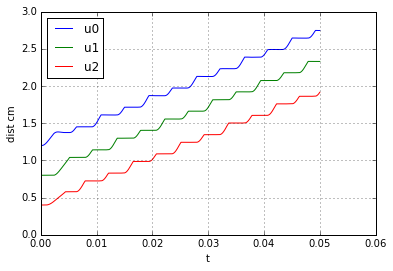

In [11]:
plt.plot(t_s, u_3[:,0], 'b', label='u'+str(0))
plt.plot(t_s, u_3[:,1], 'g', label='u'+str(1))
plt.plot(t_s, u_3[:,2], 'r', label='u'+str(2))


plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('dist cm')
plt.grid()
plt.show()

This is a graph depicting the crawling motion of each compartment in the body of the larvae.

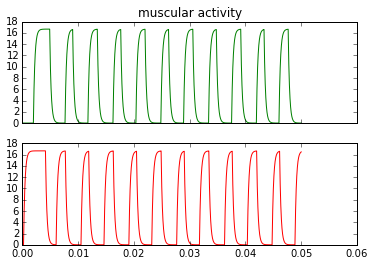

In [12]:
p_3, (ax1_3, ax2_3) = plt.subplots(2, sharex=True, sharey=True)
ax1_3.plot(t_s, f_3[:,1],'g')
ax1_3.set_title('muscular activity')
ax2_3.plot(t_s, f_3[:,2],'r')

This is a graph showing the muscular activity of each cell from cell 1 at the top to cell 2 at the bottom

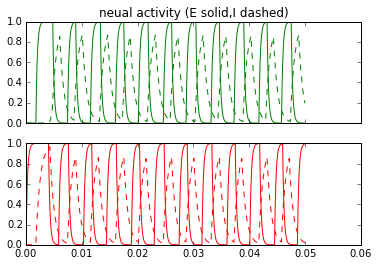

In [13]:
p_4, (ax1_3, ax2_3) = plt.subplots(2, sharex=True)
ax1_3.set_title('neual activity (E solid,I dashed) ')
ax1_3.plot(t_s, I_3[:,1],'g--')
ax1_3.plot(t_s, E_3[:,1],'g')
ax2_3.plot(t_s, I_3[:,2],'r--')
ax2_3.plot(t_s, E_3[:,2],'r')

This is a graph showing the neaural activity of each of the segments from segment 1 at the top to segment 2 at the bottom.

The larvae moves in a similar patternt to that shown in the paper. the last segment is stimulated with a impulse of 0.61 for a duration of 10*tau_e. So as we would expect this segment compresses first and since the last segment is coupled to it it also moves. The middle segment trails these two. notice that the neaural activity has a much shorter period than in the original paper. This also should be expected as there is less lenght of larvae before the cycle starts. Through experimentation i discovered that a value of 50 for k generated the behaviour required. As we will see this differs from the 11 segment model by a factor of 10. Generally I expect the more segments the smaller k has to be to generate the 'crawling' behaviour

# Larvae with 11 compartments

this is the length of larvae used in the original research paper

## variable setup

the following script sets the parameters used in the simulation and defines the time i discovered that a value of k of 5 induced crawling behaviour. I also changed the value for c from the paper st. c/(tau_E*k) = 3.5 as this is a dimensionless variable

In [14]:
t = np.linspace(0, 0.5, 100001)

L = 4/float(10)
k = 50

W = np.zeros(7)
W[0] = 1            #W_EE
W[1] = -2           #W_EI
W[2] = 0.6          #W_IE
W[3] = 0            #W_II
W[4] = 0.6          #W_En
W[5] = 1.95         #W_Ep
W[6] = 1.95         #W_Ip

tau = np.zeros(3)
tau[0] = 25 * 1e-4  #tau_E
tau[1] = 3*tau[0]   #tau_I
tau[2] = 0.4*tau[0] #tau_f

theta = np.zeros(2)
theta[0] = 0.6      #theta_E
theta[1] = 0.6      #theta_I

g = np.zeros(4)
g[0] = 40000        #g_n
g[1] = 1000         #g_p
g[2] = 1000         #g_f
g[3] = 1000         #g_F

c = 3.5*k*tau[0]

hat = np.zeros(3)
hat[2] = 5/float(12)*k*L  #f_hat
hat[1] = -17/float(18)*L   #u_hat
hat[0] = 0.4              #E_hat

maxv = np.zeros(2)
maxv[0] = 5/float(6)*k*L  #f_max
maxv[1] = 25/float(3)*k*L #F_max

the following script performs the simiulation for the 11 segment larvae. I have set the initial conditions so that at t0 E,I,h_E,h_I,f and F are all zero. The larvae is positioned so that the end of compartment 0 is postitioned at 4cm and the end of compartment 10 is positioned at 0cm. In order to get the larvae to move I added an excitatory pulse of 0.61 for a duration of 10*tau_e to compartment 10.

In [15]:
number_of_segments = 11

E0 = np.zeros(number_of_segments) 
I0 = np.zeros(number_of_segments) 
h_E0 = np.zeros(number_of_segments) 
h_I0 = np.zeros(number_of_segments) 
u0 = L*np.arange(number_of_segments)[::-1]
f0 = np.zeros(number_of_segments) 
F0 = np.zeros(number_of_segments) 

E,I,h_E,h_I,u,f,F = moving_larvae(E0,I0,h_E0,h_I0,u0,f0,F0,t,W,tau,theta,L,k,c,g,maxv,hat)

## Results

Just as in the research paper the model produces sustained crawling even once the initial exitatory pulse has been removed.

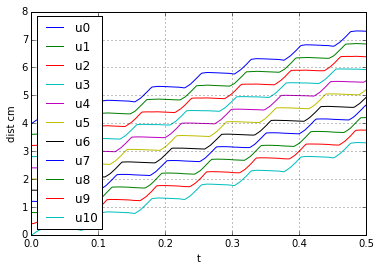

In [16]:
plt.plot(t, u[:,0], 'b', label='u'+str(0))
plt.plot(t, u[:,1], 'g', label='u'+str(1))
plt.plot(t, u[:,2], 'r', label='u'+str(2))
plt.plot(t, u[:,3], 'c', label='u'+str(3))
plt.plot(t, u[:,4], 'm', label='u'+str(4))
plt.plot(t, u[:,5], 'y', label='u'+str(5))
plt.plot(t, u[:,6], 'k', label='u'+str(6))
plt.plot(t, u[:,7], 'b', label='u'+str(7))
plt.plot(t, u[:,8], 'g', label='u'+str(8))
plt.plot(t, u[:,9], 'r', label='u'+str(9))
plt.plot(t, u[:,10], 'c', label='u'+str(10))


plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('dist cm')
plt.grid()
plt.show()

This is a graph depicting the crawling motion of each compartment in the body of the larvae. My plot differs from that in the paper by the scale of the time variable. I have also displayed distance in cm rather than the 'compartment unit' size.

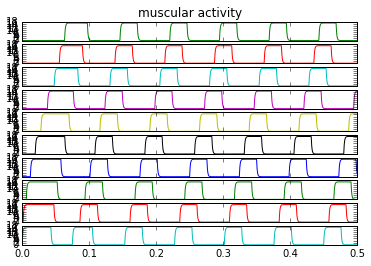

In [17]:
p, (ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(10, sharex=True, sharey=True)
ax1.plot(t, f[:,1],'g')
ax1.set_title('muscular activity')
ax2.plot(t, f[:,2],'r')
ax3.plot(t, f[:,3],'c')
ax4.plot(t, f[:,4],'m')
ax5.plot(t, f[:,5],'y')
ax6.plot(t, f[:,6],'k')
ax7.plot(t, f[:,7],'b')
ax8.plot(t, f[:,8],'g')
ax9.plot(t, f[:,9],'r')
ax10.plot(t, f[:,10],'c')


This is a graph showing the muscular activity of each cell from cell 1 at the top to cell 10 at the bottom

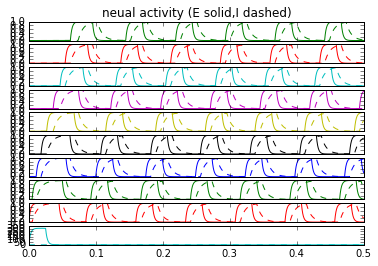

In [18]:
p_2, (ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(10, sharex=True)
ax1.set_title('neual activity (E solid,I dashed) ')
ax1.plot(t, I[:,1],'g--')
ax1.plot(t, E[:,1],'g')
ax2.plot(t, I[:,2],'r--')
ax2.plot(t, E[:,2],'r')
ax3.plot(t, I[:,3],'c--')
ax3.plot(t, E[:,3],'c')
ax4.plot(t, I[:,4],'m--')
ax4.plot(t, E[:,4],'m')
ax5.plot(t, I[:,5],'y--')
ax5.plot(t, E[:,5],'y')
ax6.plot(t, I[:,6],'k--')
ax6.plot(t, E[:,6],'k')
ax7.plot(t, I[:,7],'b--')
ax7.plot(t, E[:,7],'b')
ax8.plot(t, I[:,8],'g--')
ax8.plot(t, E[:,8],'g')
ax9.plot(t, I[:,9],'r--')
ax9.plot(t, E[:,9],'r')
ax10.plot(t, I[:,10],'c--')
ax10.plot(t, E[:,10],'c')

This is a graph showing the neaural activity of each of the segments from segment 1 at the top to segment 10 at the bottom. Interestingly my results differ from those discovered in the paper in segment 10 where no inhibitary activity is recorded and only one 'burst' of excitatory activity is seen

# Longer larvae

If we investigate longer larvae then we can show they demonstrate the same behaviour if a k of a 10th the size is used. Further investigations should be conducted to discover if the pattern continues with k needing to decrese by a factor of 10 as the number of segments doubles

In [19]:
t_l = np.linspace(0, 0.5, 100001)

L = 4/float(10)
k = 0.5

W = np.zeros(7)
W[0] = 1            #W_EE
W[1] = -2           #W_EI
W[2] = 0.6          #W_IE
W[3] = 0            #W_II
W[4] = 0.6          #W_En
W[5] = 1.95         #W_Ep
W[6] = 1.95         #W_Ip

tau = np.zeros(3)
tau[0] = 25 * 1e-4  #tau_E
tau[1] = 3*tau[0]   #tau_I
tau[2] = 0.4*tau[0] #tau_f

theta = np.zeros(2)
theta[0] = 0.6      #theta_E
theta[1] = 0.6      #theta_I

g = np.zeros(4)
g[0] = 40000        #g_n
g[1] = 1000         #g_p
g[2] = 1000         #g_f
g[3] = 1000         #g_F

c = 3.5*k*tau[0]

hat = np.zeros(3)
hat[2] = 5/float(12)*k*L  #f_hat
hat[1] = -17/float(18)*L   #u_hat
hat[0] = 0.4              #E_hat

maxv = np.zeros(2)
maxv[0] = 5/float(6)*k*L  #f_max
maxv[1] = 25/float(3)*k*L #F_max

In [20]:
number_of_segments = 20

E0 = np.zeros(number_of_segments) 
I0 = np.zeros(number_of_segments) 
h_E0 = np.zeros(number_of_segments) 
h_I0 = np.zeros(number_of_segments) 
u0 = L*np.arange(number_of_segments)[::-1]
f0 = np.zeros(number_of_segments) 
F0 = np.zeros(number_of_segments) 

E_l,I_l,h_E_l,h_I_l,u_l,f_l,F_l = moving_larvae(E0,I0,h_E0,h_I0,u0,f0,F0,t_l,W,tau,theta,L,k,c,g,maxv,hat)

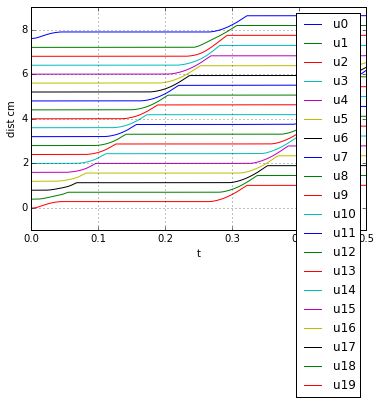

In [21]:
plt.plot(t_l, u_l[:,0], 'b', label='u'+str(0))
plt.plot(t_l, u_l[:,1], 'g', label='u'+str(1))
plt.plot(t_l, u_l[:,2], 'r', label='u'+str(2))
plt.plot(t_l, u_l[:,3], 'c', label='u'+str(3))
plt.plot(t_l, u_l[:,4], 'm', label='u'+str(4))
plt.plot(t_l, u_l[:,5], 'y', label='u'+str(5))
plt.plot(t_l, u_l[:,6], 'k', label='u'+str(6))
plt.plot(t_l, u_l[:,7], 'b', label='u'+str(7))
plt.plot(t_l, u_l[:,8], 'g', label='u'+str(8))
plt.plot(t_l, u_l[:,9], 'r', label='u'+str(9))
plt.plot(t_l, u_l[:,10], 'c', label='u'+str(10))
plt.plot(t_l, u_l[:,11], 'b', label='u'+str(11))
plt.plot(t_l, u_l[:,12], 'g', label='u'+str(12))
plt.plot(t_l, u_l[:,13], 'r', label='u'+str(13))
plt.plot(t_l, u_l[:,14], 'c', label='u'+str(14))
plt.plot(t_l, u_l[:,15], 'm', label='u'+str(15))
plt.plot(t_l, u_l[:,16], 'y', label='u'+str(16))
plt.plot(t_l, u_l[:,17], 'k', label='u'+str(17))
plt.plot(t_l, u_l[:,18], 'g', label='u'+str(18))
plt.plot(t_l, u_l[:,19], 'r', label='u'+str(19))



plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('dist cm')
plt.grid()
plt.show()

Notice also the speed of movement is darastically reduced with more segments added this may be a reason why larvae have not evolved to be longer than about 11 segments.